In [1]:
#import libraries
import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# import and process the data
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels
labels = data[:,0]
data = data[:,1:]

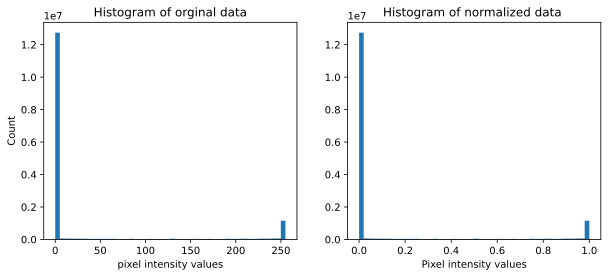

In [3]:
# normalize the data to a range [0 1]
datanorm = data/np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of orginal data')

ax[1].hist(datanorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_title('Histogram of normalized data ')

plt.show()


# create train/test groups using DataLoader

In [4]:
# convert to Tensor 
dataT = torch.tensor(datanorm).float()
labelsT = torch.tensor(labels).long() # long = int64

#use sckitlearn to split the data
train_data,test_data,train_labels,test_labels = train_test_split(dataT,labelsT,test_size=.1)

# convert into pytorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

# translate into DataLoader objects
batchsize = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])



In [5]:
# check all variable in workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT              Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
datanorm           ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
display            module           <module 'IPython.display'<...>ages/IPython/display.py'>
fig                Figure           Figure(720x288)
labels             ndarray          20000: 20000 elems, type `float64`, 1

# Create the DL model

In [6]:
# create a class for the model

def createTheMnistNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784,64)

            # hidden layer
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # output layer
            self.output = nn.Linear(32,10)

        # forward pass

        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return torch.log_softmax(self.output(x),axis=1)
            # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss

    # create the model instance
    net = mnistNet()

    #loss function
    lossfun = nn.NLLLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=.01)

    return net,lossfun,optimizer 

In [7]:
# test the model with one batch
net,lossfun,optimizer = createTheMnistNet()
X,y = iter(train_loader).next()
yHat = net(X)

# values are log-probabilty of each number 0-9
print(torch.exp(yHat))

loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)


tensor([[0.1027, 0.0982, 0.1051, 0.0973, 0.1156, 0.0910, 0.0971, 0.0843, 0.0990,
         0.1095],
        [0.1018, 0.0985, 0.1067, 0.0978, 0.1147, 0.0913, 0.0963, 0.0843, 0.0992,
         0.1094],
        [0.1021, 0.0986, 0.1062, 0.0976, 0.1145, 0.0909, 0.0967, 0.0844, 0.1005,
         0.1084],
        [0.1032, 0.0977, 0.1053, 0.0981, 0.1162, 0.0926, 0.0963, 0.0841, 0.0960,
         0.1106],
        [0.1023, 0.0978, 0.1049, 0.0972, 0.1167, 0.0921, 0.0964, 0.0842, 0.0973,
         0.1110],
        [0.1016, 0.0979, 0.1065, 0.0984, 0.1140, 0.0915, 0.0970, 0.0838, 0.0993,
         0.1100],
        [0.1011, 0.0985, 0.1060, 0.0979, 0.1144, 0.0917, 0.0964, 0.0839, 0.0997,
         0.1103],
        [0.1023, 0.0972, 0.1053, 0.0981, 0.1156, 0.0925, 0.0964, 0.0841, 0.0979,
         0.1106],
        [0.1018, 0.0990, 0.1062, 0.0978, 0.1134, 0.0918, 0.0968, 0.0827, 0.0992,
         0.1113],
        [0.1024, 0.0980, 0.1055, 0.0978, 0.1149, 0.0916, 0.0966, 0.0843, 0.0996,
         0.1093],
        [0

In [8]:
# create a function that trains the model

def function2trainTheModel():
    # number of epochs
    numepochs = 60

    # create a new model
    net,lossfun,optimizer = createTheMnistNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat,axis=1)==y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)
        
        # end of batch loop

        # now that we have trained through the batches , get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X,y = next(iter(test_loader))
        yHat = net(X)

        #compare the following really long-line of code to the training accuracy lines

        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

        #end epochs

        #function output
    return trainAcc,testAcc,losses,net



In [9]:
# run the model and show the results
trainAcc,testAcc,losses,net = function2trainTheModel()

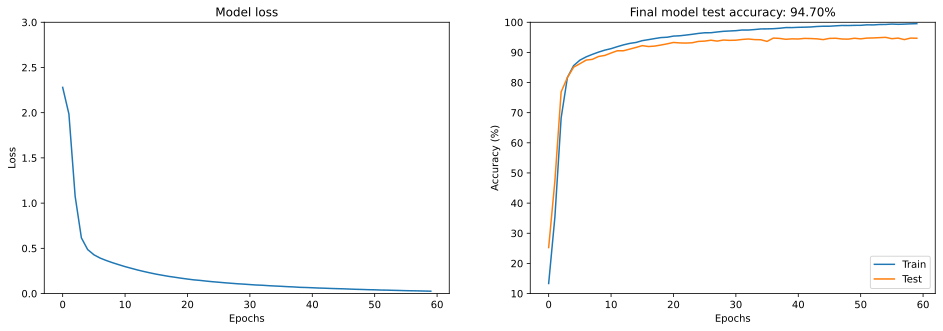

In [10]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [12]:
#Inspect the results
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-1.1784e+01, -2.0066e+01, -4.3559e+00,  ..., -1.7850e+01,
         -1.5459e-02, -5.9913e+00],
        [-6.2619e+00, -1.4989e+01, -1.1110e+01,  ..., -1.7859e+01,
         -1.4000e+01, -1.6644e+01],
        [-2.2085e-02, -1.6545e+01, -1.2162e+01,  ..., -1.0733e+01,
         -8.6475e+00, -9.3417e+00],
        ...,
        [-1.8405e+01, -1.4189e+01, -2.0046e-03,  ..., -6.2154e+00,
         -1.3015e+01, -1.6172e+01],
        [-1.2575e+01, -8.7529e+00, -3.7395e+00,  ..., -3.2289e-02,
         -9.5699e+00, -4.9068e+00],
        [-2.8842e+01, -2.6530e+01, -3.5902e+01,  ..., -1.6457e+01,
         -1.9016e+01, -1.0851e+01]])

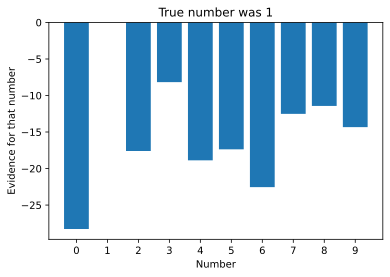

In [13]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  66   70   96  125  138  152  168  177  191  215  247  248  253  257
  266  271  313  327  349  415  499  507  513  568  582  600  610  611
  635  636  674  682  703  718  721  821  858  891  903  914  915  917
  946  984  985  988 1045 1046 1050 1059 1073 1103 1134 1136 1144 1179
 1182 1203 1206 1213 1229 1261 1263 1265 1268 1272 1306 1310 1330 1347
 1396 1401 1418 1432 1434 1440 1463 1484 1512 1529 1542 1549 1566 1570
 1646 1679 1704 1733 1740 1747 1750 1756 1761 1785 1787 1794 1833 1842
 1844 1860 1875 1894 1906 1919 1973 1983]


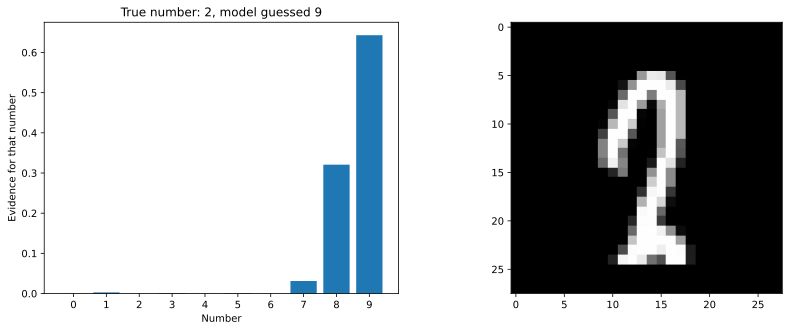

In [15]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 15

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()